# Starbucks Data Science Project


## 1. Introduction:

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). 

## 2. Datasets:


The data is contained in three files:
1. portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
2. profile.json - demographic data for each customer
3. transcript.json - records for transactions, offers received, offers viewed, and offers completed


Here is the schema and explanation of each variable in the files:

1. portfolio.json
    - id (string) - offer id
    - offer_type (string) - type of offer ie BOGO, discount, informational
    - difficulty (int) - minimum required spend to complete an offer
    - reward (int) - reward given for completing an offer
    - duration (int) - time for offer to be open, in days
    - channels (list of strings)
    
    
2. profile.json

    - age (int) - age of the customer
    - became_member_on (int) - date when customer created an app account
    - gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    - id (str) - customer id
    - income (float) - customer's income
    

3. transcript.json

    - event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    - person (str) - customer id
    - time (int) - time in hours since start of test. The data begins at time t=0
    -value - (dict of strings) - either an offer id or transaction amount depending on the record

## 3. Importing libraries and data

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
%matplotlib inline


In [2]:
# Keeping only 2 digits after decimal
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

#### With reference to the python file other_functions.py lets work on cleaning and analyzing the data

## 4. Data Wrangling, Data Analysis and Visualization

#### - Working with the portfolio data:

In [4]:
# Viewing the offer portfolio data
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.00,10.00,10.00
mean,4.20,7.70,6.50
std,3.58,5.83,2.32
min,0.00,0.00,3.00
25%,2.00,5.00,5.00
50%,4.00,8.50,7.00
75%,5.00,10.00,7.00
max,10.00,20.00,10.00


In [115]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [120]:
portfolio.groupby('offer_type')['duration'].value_counts()

offer_type     duration
bogo           5           2
               7           2
discount       7           2
               10          2
informational  3           1
               4           1
Name: duration, dtype: int64

Steps to clean this portfolio data:
- Change the name of the 'id' column to 'offerid'
- Change the name of the 'duration' column to 'durationdays'
- Remove underscores from column names
- One hot encode the 'offertype' column
- One hot encode the 'channels' columns
- Replace the 'offertype' and 'channels' columns with their respective encoded values

In [7]:
# change the duration from day to hour and then apply one hot encoding to channels, offer_type column
# combine the portfolio and offer_type dataframe to form a cleaned dataframe

def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24

    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [8]:
# Code: To clean the portfolio data
cleaned_portfolio = clean_portfolio(portfolio)

In [9]:
# Test:
cleaned_portfolio

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


#### - Working with the profile data:

In [10]:
# Viewing the profile data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,nan
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.00
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,nan
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.00
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,nan


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.00,17000.00,14825.00
mean,62.53,20167034.23,65404.99
std,26.74,11677.50,21598.30
min,18.00,20130729.00,30000.00
25%,45.00,20160526.00,49000.00
50%,58.00,20170802.00,64000.00
75%,73.00,20171230.00,80000.00
max,118.00,20180726.00,120000.00


In [13]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
# All the missing age values are encoded as 62.5 (mean age taken from the statistics above) 
# and then drop all missing data. Convert the became_member_on into a datetime format and calculate the number of days 
# being a member with respect to today's date


def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 62.5 else x)
    
    profile.dropna(inplace=True)
    
    profile['memberdays'] = pd.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    
    return profile

In [15]:
cleaned_profile = clean_profile(profile)

/Users/havishamadhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [16]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.00,1035
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.00,1102
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.00,750
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.00,826
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.00,916


In [17]:
cleaned_profile.describe()

,age,became_member_on,income,memberdays
count,14825.00,14825.00,14825.00,14825.00
mean,54.39,20166887.15,65404.99,1181.48
std,17.38,11885.65,21598.30,419.21
min,18.00,20130729.00,30000.00,659.00
25%,42.00,20160520.00,49000.00,867.00
50%,55.00,20170802.00,64000.00,1017.00
75%,66.00,20171230.00,80000.00,1456.00
max,101.00,20180726.00,120000.00,2482.00


In [127]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
 5   memberdays        14825 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 810.7+ KB


#### The users have an annual income range of 60k to 80k 

Text(0.5, 1.0, 'Income Range of the users')

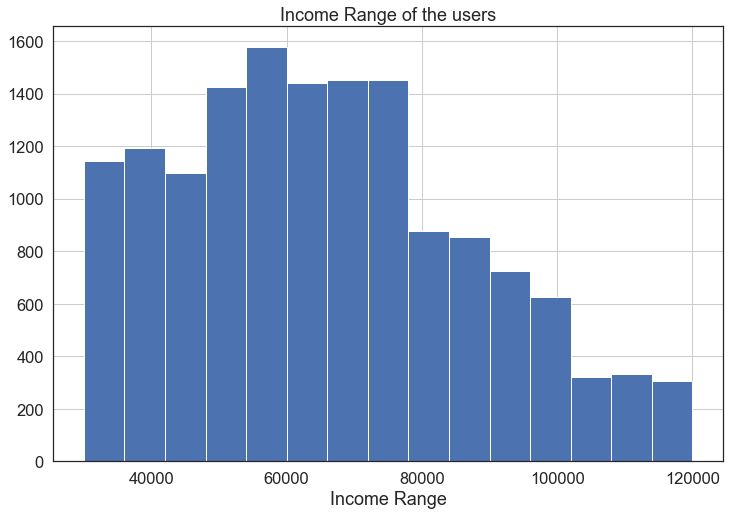

In [135]:
plt.figure(figsize=(12,8))
cleaned_profile.income.hist(bins=15)
plt.xlabel("Income Range")
plt.title("Income Range of the users")

In [123]:
cleaned_profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5, 0, 'Customer Age')

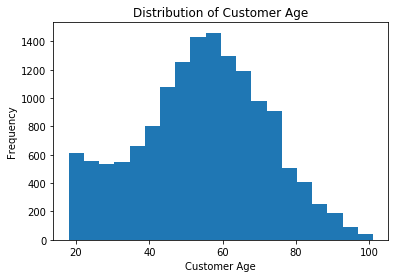

In [19]:
# Visualization for the age distributions of the customers

user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
user_age.set_xlabel("Customer Age")

Text(0.5, 0, 'Days')

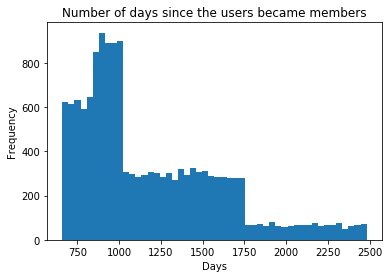

In [20]:
# Visualization for the Number of days being a member

memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=50, title='Number of days since the users became members')
memberdays.set_xlabel("Days")

Text(0.5, 0, 'Income')

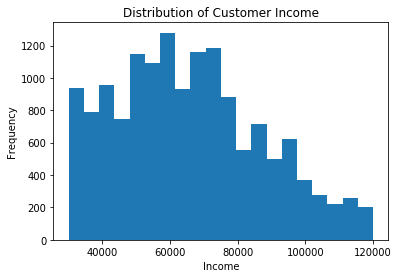

In [21]:
# Visualization for the distribution of the users' income

user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
user_income.set_xlabel("Income")

#### - Working with the transcript data

In [22]:
# Viewing the transcript data
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [23]:
# Number of event types

transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [24]:
# Randomly selecting one user and exploring the transcript records and flow of events
transcript[transcript['person']=='a03223e636434f42ac4c3df47e8bac43']

,person,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
15562,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},6
90553,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 1.09},234
97700,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 3.5},264
110829,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
123539,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
150599,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408
201573,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
245125,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},576
277104,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 0.06},612


In [25]:
# extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
# Excluding 'transaction' of the events
# extract the offer id from value column
    
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [26]:
offer = clean_transcript(transcript)

/Users/havishamadhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

#### We can see below that the offer received per person in the transactional data could range from 1 to 6 offers received. 

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


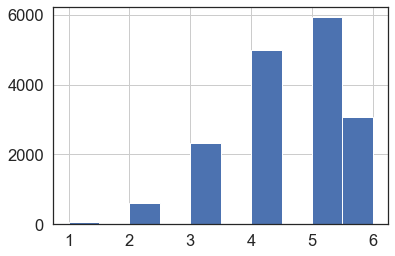

In [138]:
#group event=offer received per person in transactional records
print(offer[offer['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
offer[offer['event']=='offer received'].groupby('person')['event'].count().hist()

#### Customer gender distribution attribute: Greater male users

M    8484
F    6129
O     212
Name: gender, dtype: int64


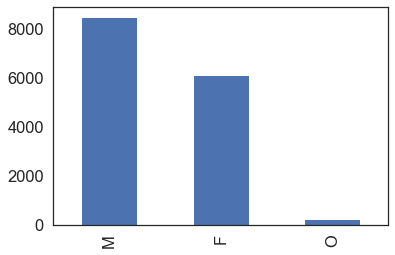

In [109]:
gender_counts = cleaned_profile['gender'].value_counts()
print(gender_counts)
gender_counts.plot(kind = 'bar')

#### Which year attracted maximum subscribers : 2017 attracted maximum customers

2017   37.77
2018   24.75
2016   20.40
2015   10.77
2014    4.47
2013    1.85
Name: became_member_on, dtype: float64


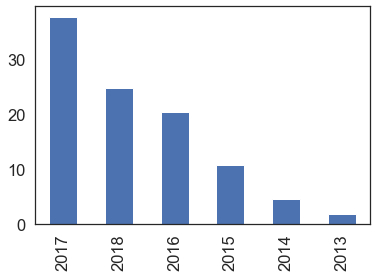

In [110]:
became_member_on = cleaned_profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
print(start_year)
start_year.plot(kind = 'bar')

#### Which month attracts most subscribers: August, October and December usually attract maximum customers

8    9.41
10   9.35
12   9.25
1    8.95
9    8.76
11   8.55
7    8.02
5    7.77
4    7.72
3    7.72
6    7.45
2    7.03
Name: became_member_on, dtype: float64


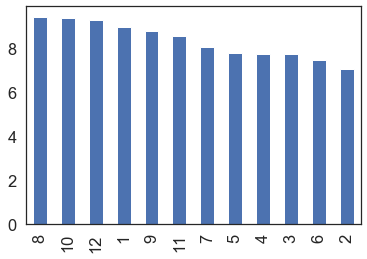

In [111]:
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
print(start_month)
start_month.plot(kind='bar')

## 5. Data Modeling

In [36]:
# Concentrating only on BOGO and discounts first


def create_user_item_matrix(offer):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''   
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
 #   fh = open(filename, 'wb')
  #  pickle.dump(user_item_matrix,fh)
  #  fh.close()
    
    return user_item_matrix

In [38]:
df = create_user_item_matrix(offer)

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [39]:
df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,nan,nan,0.00,nan,nan,nan,0.00,0.00
00116118485d4dfda04fdbaba9a87b5c,nan,nan,nan,nan,nan,nan,0.00,nan
0011e0d4e6b944f998e987f904e8c1e5,1.00,1.00,nan,nan,1.00,nan,nan,nan
0020c2b971eb4e9188eac86d93036a77,nan,nan,nan,1.00,nan,0.00,nan,1.00
0020ccbbb6d84e358d3414a3ff76cffd,nan,1.00,nan,nan,1.00,nan,1.00,nan


In [40]:
# Checking the size of the training and test sets
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [41]:
train_offer = offer[:train_size]

In [42]:
test_offer = offer[train_size:]


In [43]:
train_df = create_user_item_matrix(train_offer)

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [45]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,nan,nan,nan,nan,nan,nan,0.00,0.00
00116118485d4dfda04fdbaba9a87b5c,nan,nan,nan,nan,nan,nan,0.00,nan
0011e0d4e6b944f998e987f904e8c1e5,0.00,1.00,nan,nan,0.00,nan,nan,nan
0020c2b971eb4e9188eac86d93036a77,nan,nan,nan,0.00,nan,0.00,nan,1.00
0020ccbbb6d84e358d3414a3ff76cffd,nan,1.00,nan,nan,0.00,nan,1.00,nan


In [46]:
test_df = create_user_item_matrix(test_offer)

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [47]:
test_df.head()


offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,nan,nan,0.00,nan,nan,nan,nan,0.00
00116118485d4dfda04fdbaba9a87b5c,nan,nan,nan,nan,nan,nan,0.00,nan
0011e0d4e6b944f998e987f904e8c1e5,0.00,nan,nan,nan,0.00,nan,nan,nan
0020c2b971eb4e9188eac86d93036a77,nan,nan,nan,0.00,nan,nan,nan,0.00
0020ccbbb6d84e358d3414a3ff76cffd,nan,nan,nan,nan,0.00,nan,nan,nan


In [49]:
def matrxfact(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [50]:
train_data_np = np.array(train_df)
user_mat, offer_mat = matrxfact(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.317319
2 		 0.267773
3 		 0.267419
4 		 0.267054
5 		 0.266685
6 		 0.266311
7 		 0.265932
8 		 0.265547
9 		 0.265157
10 		 0.264759
11 		 0.264355
12 		 0.263943
13 		 0.263524
14 		 0.263095
15 		 0.262657
16 		 0.262209
17 		 0.261751
18 		 0.261281
19 		 0.260798
20 		 0.260302
21 		 0.259792
22 		 0.259266
23 		 0.258724
24 		 0.258164
25 		 0.257586
26 		 0.256987
27 		 0.256366
28 		 0.255723
29 		 0.255054
30 		 0.254359
31 		 0.253636
32 		 0.252883
33 		 0.252097
34 		 0.251278
35 		 0.250422
36 		 0.249528
37 		 0.248593
38 		 0.247615
39 		 0.246591
40 		 0.245519
41 		 0.244396
42 		 0.243220
43 		 0.241988
44 		 0.240697
45 		 0.239345
46 		 0.237929
47 		 0.236447
48 		 0.234896
49 		 0.233274
50 		 0.231579
51 		 0.229809
52 		 0.227962
53 		 0.226036
54 		 0.224031
55 		 0.221945
56 		 0.219778
57 		 0.217530
58 		 0.215201
59 		 0.212792
60 		 0.210303
61 		 0.207737
62 		 0.205095
63 		 0.202380
64 		 0

In [52]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = matrxfact(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.292305
2 		 0.266066
3 		 0.265600
4 		 0.265132
5 		 0.264662
6 		 0.264190
7 		 0.263716
8 		 0.263239
9 		 0.262760
10 		 0.262278
11 		 0.261793
12 		 0.261305
13 		 0.260813
14 		 0.260319
15 		 0.259820
16 		 0.259317
17 		 0.258810
18 		 0.258298
19 		 0.257781
20 		 0.257259
21 		 0.256731
22 		 0.256197
23 		 0.255657
24 		 0.255109
25 		 0.254554
26 		 0.253991
27 		 0.253420
28 		 0.252840
29 		 0.252250
30 		 0.251649
31 		 0.251038
32 		 0.250415
33 		 0.249780
34 		 0.249131
35 		 0.248469
36 		 0.247791
37 		 0.247098
38 		 0.246387
39 		 0.245659
40 		 0.244911
41 		 0.244144
42 		 0.243355
43 		 0.242543
44 		 0.241707
45 		 0.240847
46 		 0.239959
47 		 0.239043
48 		 0.238098
49 		 0.237122
50 		 0.236113
51 		 0.235069
52 		 0.233990
53 		 0.232872
54 		 0.231716
55 		 0.230518
56 		 0.229278
57 		 0.227993
58 		 0.226662
59 		 0.225283
60 		 0.223854
61 		 0.222375
62 		 0.220844
63 		 0.219258
64 		 0

In [53]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        return None


In [54]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [55]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.33136567185633087


In [57]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [58]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.66
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.77
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.36
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.25
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.24
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.09
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.03
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.17


In [60]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

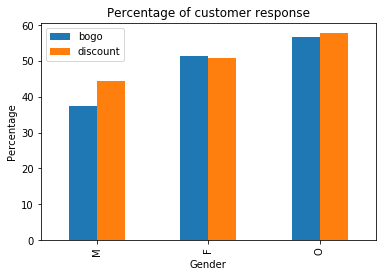

In [61]:
gender_offer(df)

In [62]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

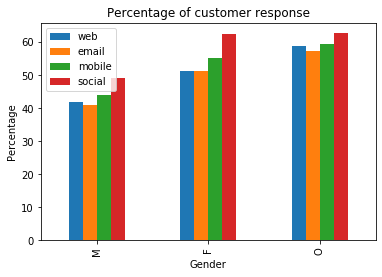

In [63]:
gender_offer_channel(df)

In [64]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id      gain
7  fafdcd668e3743c1bb461111dcafc2a4 596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2 538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d 480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0 441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd 423683.27
2  2906b810c7d4411798c6938adc9daaa5 305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9 304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7 218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


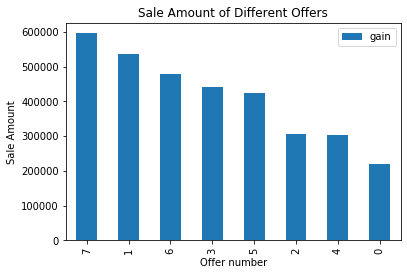

In [65]:
best_sale_offer(df)

In [147]:
# offer_if of the best sale
offer[offer.values=='fafdcd668e3743c1bb461111dcafc2a4']

,person,event,value,time,offer_id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
15,f806632c011441378d4646567f357a21,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
29,8be4463721e14d7fa600686bf8c8b2ed,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
34,9c64321646bf40f6ad1bc98864eaa6b8,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
59,816afd4505d047cf893275fbfe825590,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...,...,...
306374,2d868dda028f445b8c7f592d33077229,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306470,452cdae2c68e4732a4177d3929562690,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


# 6. Conclusion

Based on the transcript records, we build an user-item-matrix that represents how users responded to the offers they received. 
We then split the records into the training set and the test set and trained our SVD algorithm to predict how a user responses to a particular offer.

## Results
We achieved the lowest mean square error around 0.002506 with 15 latent features (250 iterations) with the training set and around 0.003734 with 10 latent features (250 iterations) with the testing set. 
After that, we created a recommendation engine that recommends Starbucks which offer should be sent to a particular user.

Later we found out which demographic groups respond best to which offer type. 
1. Females respond much better than men, in both BOGO and discount. 
2. But men reacted better to discount than BOGO. 
3. We also found that it is better to promote the offer via social media for all gender types. 
4. Among the ten offers, sending buy 10 dollars get 2 dollars off within 10 days offer via email, web, mobile and social makes Starbucks gain more. It is the best offer so far!
